In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# The Lorenz-63 model

The first example.

## The surrogate physical process

Taken from example 1.1 of [1].

In [12]:
sigma = 10.
rho = 28.
beta = 8./3

dt = 0.001
a = 1./np.sqrt(dt)

fakt = 1.99999
N = 2 * 10**5
Nout = 50

x = -.587
y = -.563
z = 16.870

g1 = a * (1./np.sqrt(2) - 0.5)
g2 = a * (1./np.sqrt(3) - 0.5)
g3 = a * (1./np.sqrt(5) - 0.5)

res = np.zeros((N,7))

def gi(gi):
    if ((gi >= -a/2) and gi < 0):
        return a * (fakt * gi / a + 0.5)
    else:
        return a * (-fakt * gi / a + 0.5)
    
for i in range(N):
    res[i] = [i, x, y, z, g1, g2, g3]
    
    g1 = gi(g1)
    g2 = gi(g2)
    g3 = gi(g3)
        
    xn = x + dt * ((sigma * (y - x)) + g1)
    yn = y + dt * ((x * (rho - z) - y) + g2)
    zn = z + dt * ((x * y - beta * z) + g3)
    
    x = xn
    y = yn
    z = zn

res[:,0] *= dt
ressug = np.array(res[::Nout])

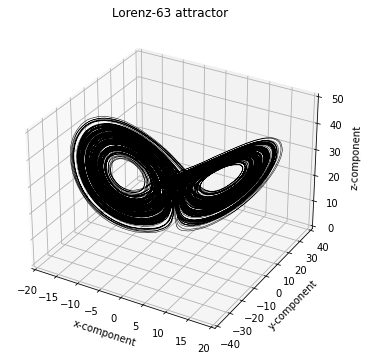

In [13]:
from mpl_toolkits import mplot3d

fig0 = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.plot3D(res[:,1],res[:,2],res[:,3], 'k', linewidth=0.5)
ax.set_xlabel('x-component')
ax.set_ylabel('y-component')
ax.set_zlabel('z-component')
ax.set_title('Lorenz-63 attractor')

ax.set_xlim(-20,20)
ax.set_ylim(-40,40)
ax.set_zlim(0,50)
plt.show()

## Adding observations
By means of the tent map iterations.

In [14]:
meas = np.zeros((N*4,2))
a = 4.
fakt = 1.99999
eta1 = a * (2**(-1./2) - 0.5)

for i in range(N*4):
    if ((eta1 >= -a/2) and (eta1 < 0)):
        eta1 = (fakt * eta1 + 0.5 * a)
    else:
        eta1 = (-fakt * eta1 + 0.5 * a)
    meas[i] = [i+1, eta1]
    
measerr = meas[:,1][::10]

obsx = np.zeros((int(N/Nout),3))

j = 0
i = 0

for k in range(1,N,Nout):
    err = 1./20 * np.sum(measerr[j:j+20])
    obsx[i] = [res[k,0], res[k,1], err]
    i += 1
    j += 20
    
obsx = np.array(obsx)
obs = [obsx[:,0], obsx[:,1] + obsx[:,2]]
obs = np.array(obs)

In [15]:
print(obs.shape)
print(obs[0,-1])
print(res[-1,0])
print(res.shape)

(2, 4000)
199.951
199.999
(200000, 7)


## Sequential data assimilation
### Extended Kalman Filter

In [46]:
STEPS = 100 # 100 windows of observations with 50 Nout each = 5000 time steps; t_end = 5
R = 1./15 # Chap2ex20: variance of observation error  (tent map iterations) = 1/15

# Chap4ex8: Forcing terms can be modeled by a stochastic term with mean ~ 0, var ~ 0.0838.
var = 0.0838
dt = 0.001

sigma = 0.1 # background error variance
    
x = -.587 + np.sqrt(sigma) * np.random.randn()
y = -.563 + np.sqrt(sigma) * np.random.randn()
z = 16.870 + np.sqrt(sigma) * np.random.randn()
t = np.zeros((STEPS+1))

B = sigma * np.eye(3)
Pf = B
Q = np.sqrt(dt * var) * np.eye(3)

sigma = 10.
rho = 28.
beta = 8./3

EKF = np.zeros((STEPS*Nout,4), dtype='object')
noEKF = np.zeros((STEPS*Nout,4), dtype='object')

EKFSIRrmse_x = 0.
EKFSIRrmse_y = 0.
EKFSIRrmse_z = 0.

def k1s(x,y,z):
    k1x = dt * sigma * (y - x)
    k1y = dt * (x * (rho - z) - y)
    k1z = dt * (x * y - beta * z)
    
    return k1x,k1y,k1z

def k2s(x,y,z,k1x,k1y,k1z):
    k2x = dt * sigma * (y + k1y - x - k1x)
    k2y = dt * ((x + k1x) * (rho - (z + k1z)) - y - k1y)
    k2z = dt * ((x + k1x) *  (y + k1y) - beta * (z + k1z))
    return k2x,k2y,k2z
    
jj = 0
for j in range(STEPS):
    xh = x.flatten()[0]
    yh = y.flatten()[0]
    zh = z.flatten()[0]
    
    if j == 0:
        x_num = np.copy(x)
        y_num = np.copy(y)
        z_num = np.copy(z)

    for i in range(Nout):
        xo = xh
        yo = yh
        zo = zh
        EKF[jj] = [jj,xo,yo,zo]
        noEKF[jj] = [jj,x_num,y_num,z_num]
    
        # modified Euler method for the Lorenz-63 model
        k1x,k1y,k1z = k1s(xo,yo,zo)
        k2x,k2y,k2z = k2s(xo,yo,zo,k1x,k1y,k1z)
        
        x_num = x_num + 0.5 * (k1x + k2x) + np.sqrt(dt * var) * np.random.randn()
        y_num = y_num + 0.5 * (k1y + k2y) + np.sqrt(dt * var) * np.random.randn()
        z_num = z_num + 0.5 * (k1z + k2z) + np.sqrt(dt * var) * np.random.randn()

        xh = xo + 0.5 * (k1x + k2x) + np.sqrt(dt * var) * np.random.randn()
        yh = yo + 0.5 * (k1y + k2y) + np.sqrt(dt * var) * np.random.randn()
        zh = zo + 0.5 * (k1z + k2z) + np.sqrt(dt * var) * np.random.randn()
        
        dxh,dyh,dzh = k1s(xh,yh,zh)
        A = dt*np.array([[-sigma, sigma,0.],[rho-zh,-1.,-xh],[yh,xh,-beta]])
        B = dt*np.array([[-sigma, sigma,0.],[rho-(zh+dzh),-1.,-(xh+dxh)],[(yh+dyh),(xh+dxh),-beta]])
        
        M = np.eye(3) + 0.5 * (np.dot(B,(A+np.eye(3))) + A)
        Pf = np.dot(np.dot(M,Pf),M.T) + Q
        
        jj += 1

    # Calculate residual: (forward map of reference - yobs)
    r = xh - obs[1,j+1]
    
    x = xh
    y = yh
    z = zh
    
    # Get the Kalman gain matrix K.
    Xf = np.vstack((x,y,z))
    K = Pf[:,0] / (Pf[0,0] + R)
    Xa = Xf - K.reshape(3,1)*r
    
    x = Xa[0]
    y = Xa[1]
    z = Xa[2]

    EKFSIRrmse_x += (x - ressug[j+1,1])**2
    EKFSIRrmse_y += (y - ressug[j+1,2])**2
    EKFSIRrmse_z += (z - ressug[j+1,3])**2

EKFSIRrmse_x = np.sqrt(EKFSIRrmse_x / STEPS)
EKFSIRrmse_y = np.sqrt(EKFSIRrmse_y / STEPS)
EKFSIRrmse_z = np.sqrt(EKFSIRrmse_z / STEPS)

EKF[:,0] *= dt 
noEKF[:,0] *= dt

In [47]:
print(EKFSIRrmse_x)
print(EKFSIRrmse_y)
print(EKFSIRrmse_z)

[0.27617563]
[3.21415815]
[3.91932566]


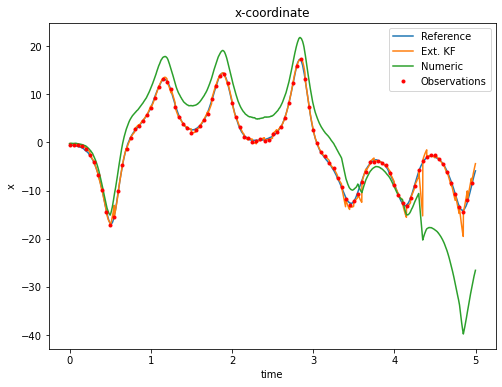

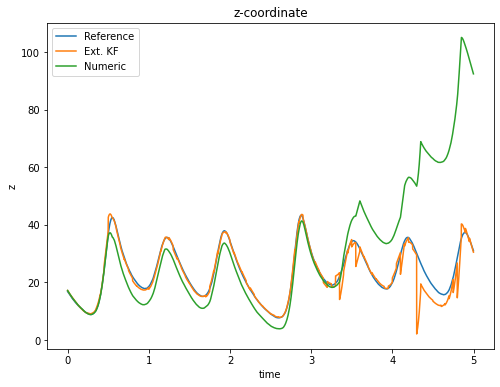

In [48]:
fig0a = plt.figure(figsize=(8,6))
plt.plot(res[:5000,0],res[:5000,1])
plt.plot(EKF[:,0],EKF[:,1])
plt.plot(noEKF[:,0],noEKF[:,1])
plt.plot(obs[0,:100],obs[1,:100],'ro', ms=3.)
plt.legend(["Reference","Ext. KF", "Numeric", "Observations"])
plt.title("x-coordinate")
plt.xlabel("time")
plt.ylabel("x")
plt.show()

fig0b = plt.figure(figsize=(8,6))
plt.plot(res[:5000,0],res[:5000,3])
plt.plot(EKF[:,0],EKF[:,3])
plt.plot(noEKF[:,0],noEKF[:,3])
#plt.plot(obs[0,:100],obs[1,:100],'ro', ms=3.)
plt.legend(["Reference","Ext. KF", "Numeric"])
plt.title("z-coordinate")
plt.xlabel("time")
plt.ylabel("z")
plt.show()

### Sequential Importance Resampling (SIR) Filter
Taken from example 6.11 of [1].

In [49]:
# Import resampling function
import resampling

In [53]:
STEPS = 5*40 # number of windows of observations
R = 1./15

# recall that from example 4.8, the Lorenz model with drift term f(x) set to zero can be modelled 
# by a stochastic difference equation with mean = 0, var = 0.0838.
var = 0.0838
sigma = 0.1

NN = 6
m = np.zeros((NN))
SIRrmse_x = np.zeros((NN))
SIRrmse_y = np.zeros((NN))
SIRrmse_z = np.zeros((NN))
effective = np.zeros((NN,STEPS+1))

m = np.arange(50,300+50,50)

for lkl in range(NN):
    # ensemble size
    M = m[lkl]
    
    x0 = -.587
    y0 = -.563
    z0 = 16.870
    
    # initial PDF is Gaussian with var = 0.1, mean = (x0,y0,z0)
    x = x0 + np.sqrt(sigma) * np.random.randn(M)
    y = y0 + np.sqrt(sigma) * np.random.randn(M)
    z = z0 + np.sqrt(sigma) * np.random.randn(M)
    t = np.zeros((STEPS+1))
    
    weights = 1./M * np.ones((M))
    
    x_f = np.zeros((STEPS+1))
    y_f = np.zeros((STEPS+1))
    z_f = np.zeros((STEPS+1))
    
    x_f[0] = np.dot(weights.T,x)
    y_f[0] = np.dot(weights.T,y)
    z_f[0] = np.dot(weights.T,z)

    SIRrmse_x[lkl] = 0.
    SIRrmse_y[lkl] = 0.
    SIRrmse_z[lkl] = 0.
    
    effective[lkl,0] = 1. / np.sum(weights**2)

    for j in range(STEPS):
        xh = x
        yh = y
        zh = z
        
        for i in range(Nout):
            xo = xh
            yo = yh
            zo = zh

            # step within each observation window by means of the stochastiv Lorenz-63 model
            xh = xo + dt * 10. * (yo - xo) + np.sqrt(dt * var) * np.random.randn(M)
            yh = yo + dt * (xo * (28. - zo) - yo) + np.sqrt(dt * var) * np.random.randn(M)
            zh = zo + dt * (xo * yo - 8./3 * zo) + np.sqrt(dt * var) * np.random.randn(M)

        # Calculate residual: (forward map of reference - yobs)
        r = xh - obs[1,j+1]
        
        # Update weights according to equation 6.29
        weights = np.exp(-r**2 / (R * 2.)) * weights
        weights /= np.sum(weights)

        x = xh
        y = yh
        z = zh
        
        x_f[j+1] = np.dot(weights,x)
        y_f[j+1] = np.dot(weights,y)
        z_f[j+1] = np.dot(weights,z)
        t[j+1] = dt * Nout * (j+1)
    
        SIRrmse_x[lkl] = SIRrmse_x[lkl] + (x_f[j+1] - ressug[j+1,1])**2
        SIRrmse_y[lkl] = SIRrmse_y[lkl] + (y_f[j+1] - ressug[j+1,2])**2
        SIRrmse_z[lkl] = SIRrmse_z[lkl] + (z_f[j+1] - ressug[j+1,3])**2

        effective[lkl,j+1] = 1. / np.sum(weights**2)
        
        # introduce a resampling step (residual resampling)
        if (effective[lkl,j+1] < M/2.):
            X = np.vstack((x,y,z))
            A, B = resampling.resampling(X,weights,M,3)
            
            # reinitialise weights to be equal
            weights = 1./M * np.ones(M)

            x = np.hstack((A[0,:],B[0,:])).T
            y = np.hstack((A[1,:],B[1,:])).T
            z = np.hstack((A[2,:],B[2,:])).T
        
    SIRrmse_x[lkl] = np.sqrt(SIRrmse_x[lkl] / STEPS)
    SIRrmse_y[lkl] = np.sqrt(SIRrmse_y[lkl] / STEPS)
    SIRrmse_z[lkl] = np.sqrt(SIRrmse_z[lkl] / STEPS)

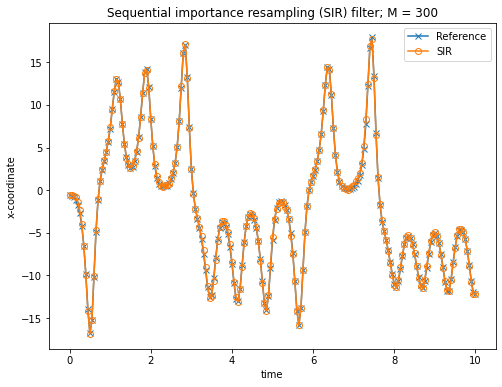

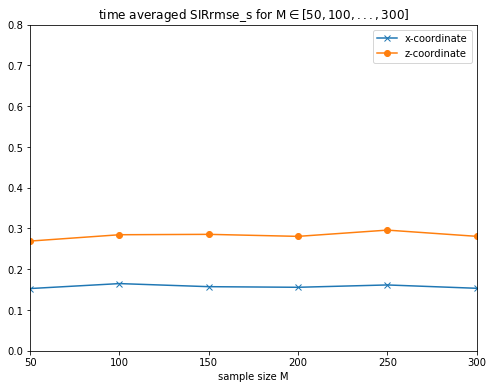

In [54]:
# fig3a = plt.figure(figsize=(8,6))
# plt.plot(t,effective.T)
# plt.xlabel("time")
# plt.title("effective sample size")
# plt.xlim([0,10.])
# plt.show()

fig1a = plt.figure(figsize=(8,6))
plt.plot(t,ressug[:201,1], '-x', mfc="None")
plt.plot(t,x_f, '-o', mfc="None")
plt.legend(["Reference", "SIR"])
plt.title("Sequential importance resampling (SIR) filter; M = 300")
plt.ylabel("x-coordinate")
plt.xlabel("time")
plt.show()

fig1b = plt.figure(figsize=(8,6))
plt.plot(m,SIRrmse_x, '-x', label="x-coordinate")
plt.plot(m,SIRrmse_z, '-o', label="z-coordinate")

plt.xlabel("sample size M")
plt.title("time averaged SIRrmse_s for M$\in[50,100,...,300]$")
plt.xlim([50,300])
plt.ylim([0,0.8])
plt.legend()
plt.show()

### 4D-Var

In [55]:
# Perform 4DVar
NA = 5
CYCLES = 40
alpha = 0.025

R = 1./15
delta = 0.25
var = 0.0838

np.random.seed(555)
sigma = delta
x0 = -.587 + np.sqrt(sigma) * np.random.randn()
y0 = -.563 + np.sqrt(sigma) * np.random.randn()
z0 = 16.870 + np.sqrt(sigma) * np.random.randn()

x_anal = np.zeros((CYCLES*NA+1))
y_anal = np.zeros((CYCLES*NA+1))
z_anal = np.zeros((CYCLES*NA+1))

x_fore = np.zeros((CYCLES*NA+1))
y_fore = np.zeros((CYCLES*NA+1))
z_fore = np.zeros((CYCLES*NA+1))

rmse_X = np.zeros((8))
rmse_Y = np.zeros((8))
rmse_Z = np.zeros((8))
b = np.zeros((8))
    
KS = 1
x_fg = np.copy(x0)
y_fg = np.copy(y0)
z_fg = np.copy(z0)

xa = []
xf = []
tt = []

for lll in range(CYCLES):
    x = np.zeros((NA+1))
    y = np.zeros((NA+1))
    z = np.zeros((NA+1))
    
    x_num = np.zeros((NA+1))
    y_num = np.zeros((NA+1))
    z_num = np.zeros((NA+1))

    t = np.zeros((NA+1))

    xb = x_fg
    yb = y_fg
    zb = z_fg

    x[0] = np.copy(x_fg)
    y[0] = np.copy(y_fg)
    z[0] = np.copy(z_fg)
    
    x_num[0] = np.copy(x_fg)
    y_num[0] = np.copy(y_fg)
    z_num[0] = np.copy(z_fg)
    
    xa.append(x[0])
    xf.append(x_num[0])
    
    t[0] = 0.
    tt.append(t[0] + lll*0.25)

    vareps = 1.
    ll = 1
    W = []
    
    switch = True
    
    while vareps >= 1e-2:
        JAC = np.eye(3)
        H = np.array([1, 0, 0])
        dV = np.zeros((3,NA))
        r = np.zeros((NA))

        for j in range(NA):
            xh = x[j]
            yh = y[j]
            zh = z[j]

            for i in range(Nout):
                xo = xh
                yo = yh
                zo = zh

                xh = xo + dt * 10. * (yo-xo) + np.sqrt(dt * var) * np.random.randn()
                yh = yo + dt * (xo * (28. - zo) - yo) + np.sqrt(dt * var) * np.random.randn()
                zh = zo + dt * (xo * yo - 8./3 * zo) + np.sqrt(dt * var) * np.random.randn()

                # Get the Jacobian of the current iteration
                DF = np.array([[-10., 10., 0.],[28. - zo, -1., -xo],[yo, xo, -8./3]])

                # Update step for the Jacobian
                JAC = np.dot((np.eye(3) + dt * DF) , JAC)

            x[j+1] = xh
            y[j+1] = yh
            z[j+1] = zh
            
            if switch == True:
                x_num[j+1] = np.copy(xh)
                y_num[j+1] = np.copy(yh)
                z_num[j+1] = np.copy(zh)
            
            # Calculate residual: (forward map of reference - yobs)
            r[j] = xh - obs[1,j+KS]
            #print(r)
            # Gradient of the objective functional for each observation time-step
            dV[:,j] = np.dot(JAC.T,H.T*r[j])
            #print(dV)
            t[j+1] = dt * Nout * (j+1)

        # Objective functional
        W.append(.5 * np.sum(r**2) + .5 * ((x[0] - xb)**2 + (y[0] - yb)**2 + (z[0] - zb)**2) / delta)
        # Gradient of the objective functional over a data assimilation cycle
        dW = np.sum(dV, axis=1) + np.hstack((x[0] - xb, y[0] - yb, z[0] - zb)) / delta

        # Gradient descent method - want this to converge to < 1e-2.
        vareps = np.linalg.norm(dW)
        ll += 1 # Can remove this counter - unused.

        x[0] -= alpha * dW[0]
        y[0] -= alpha * dW[1]
        z[0] -= alpha * dW[2]
        
        switch = False
    
    x_anal[KS-1:KS+NA] = x
    y_anal[KS-1:KS+NA] = y
    z_anal[KS-1:KS+NA] = z
    
    x_fore[KS-1:KS+NA] = x_num
    y_fore[KS-1:KS+NA] = y_num
    z_fore[KS-1:KS+NA] = z_num
    
    xa.extend(x)
    xf.extend(x_num)
    tt.extend(t + lll*0.25)
    
    x_fg = x[-1]
    y_fg = y[-1]
    z_fg = z[-1]

    KS = KS+NA

VARrmse_X = np.sqrt(np.mean((ressug[:KS,1] - x_anal[:KS])**2))
VARrmse_Y = np.sqrt(np.mean((ressug[:KS,2] - y_anal[:KS])**2))
VARrmse_Z = np.sqrt(np.mean((ressug[:KS,3] - z_anal[:KS])**2))

0.26419967039847236
0.47731190557961123
0.5632874601047229


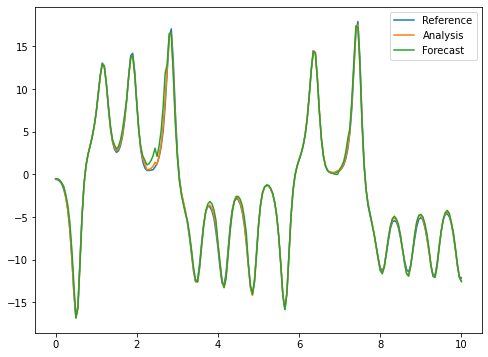

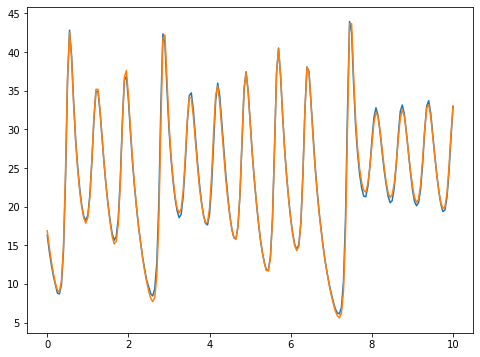

In [56]:
print(VARrmse_X)
print(VARrmse_Y)
print(VARrmse_Z)

fig2a = plt.figure(figsize=(8,6))
plt.plot(ressug[:KS,0],ressug[:KS,1])
plt.plot(ressug[:KS,0],x_anal)
plt.plot(ressug[:KS,0],x_fore)
plt.legend(["Reference","Analysis","Forecast"])
plt.show()

fig2b = plt.figure(figsize=(8,6))
plt.plot(ressug[:KS,0],z_anal[:KS])
plt.plot(ressug[:KS,0],ressug[:KS,3])
plt.show()

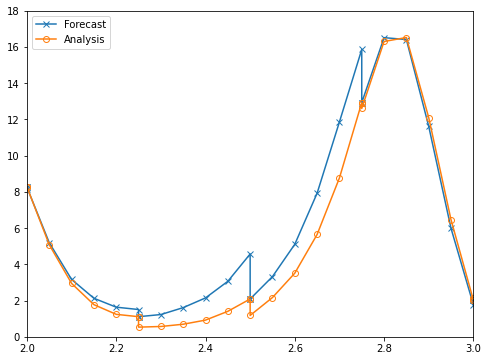

In [58]:
fig2c = plt.figure(figsize=(8,6))
plt.plot(tt,xf,'-x',mfc="None")
plt.plot(tt,xa,'-o',mfc="None")
plt.legend(["Forecast","Analysis"])
plt.xlim([2.0,3.0])
plt.ylim([0,18])
plt.show()